In [1]:
from torchdiffeq import odeint
import models_and_functions as MyModels
import torch
import numpy as np
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
df_antibiotics, antibiotic_types, df_relative_abundances= MyModels.wrangle_data()
df_relative_abundances = df_relative_abundances.drop_duplicates(subset = ['PatientID', 'DayRelativeToNearestHCT'])
test_df = pd.read_csv('node_model_test_df.csv', index_col = 0)
node_model = torch.load('node_model.pth', weights_only=False)
glv_model = torch.load('glv_model.pth', weights_only=False)
glv_model_test_df = pd.read_csv('glv_model_test_df.csv')  # note that this is a subset of the NODE test df




CUDA is available. Using GPU.
GPU Device name: NVIDIA A100 80GB PCIe
GPU Memory Allocated: 0.0 GB
GPU Memory Cached: 0.0 GB
CUDA is available. Using GPU.
GPU Device name: NVIDIA A100 80GB PCIe
GPU Memory Allocated: 0.0 GB
GPU Memory Cached: 0.0 GB


/data1/xavierj/isaac/Neural_ODEs_Paper_Code/Clinical_Data_Experiments/models_and_functions.py:31: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"GPU Memory Cached: {round(torch.cuda.memory_cached(0)/1024**3,1)} GB")
/tmp/ipykernel_212147/1625365578.py:14: FutureWarning: `torch.cuda.memory_cached` has been renamed to `torch.cuda.memory_reserved`
  print(f"GPU Memory Cached: {round(torch.cuda.memory_cached(0)/1024**3,1)} GB")


# Domination predictions

computing domination predictions...
plotting ROC curve...


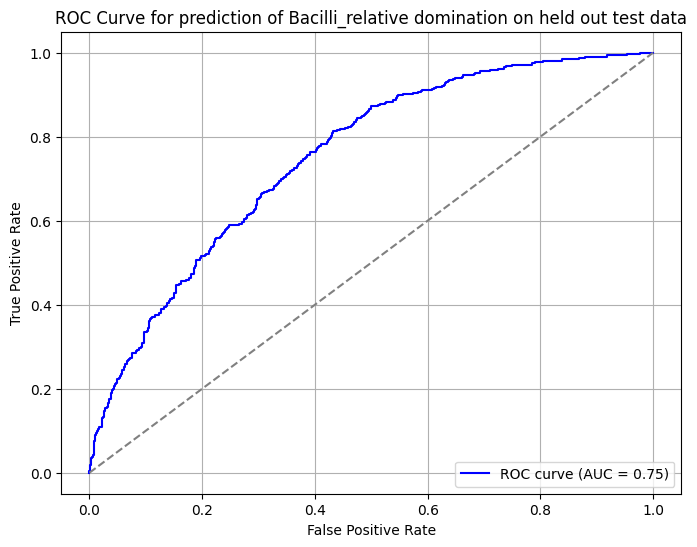

0.7508832495508047

In [2]:
test_df = pd.read_csv('node_model_test_df.csv', index_col = 0)

MyModels.make_domination_predictions(node_model, test_df, index_of_taxa=2)




computing domination predictions...
plotting ROC curve...


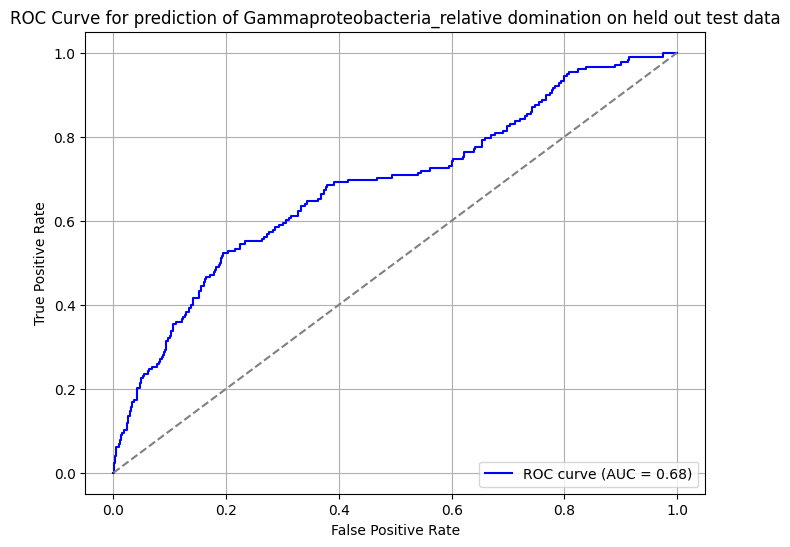

0.68397335512649

In [7]:
MyModels.make_domination_predictions(node_model, test_df, index_of_taxa=9)


computing domination predictions...
plotting ROC curve...


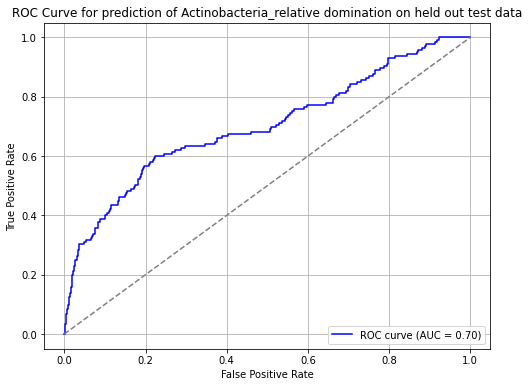

computing domination predictions...
plotting ROC curve...


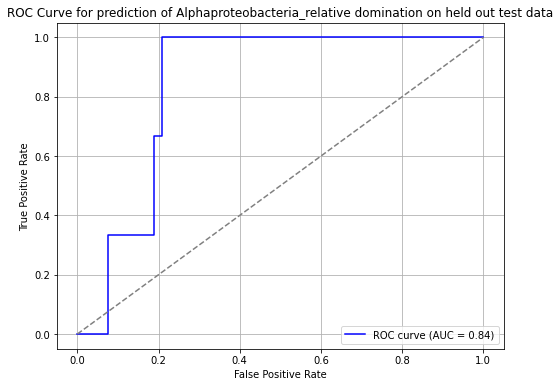

computing domination predictions...
plotting ROC curve...


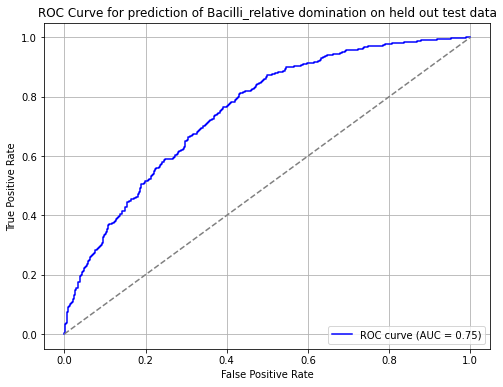

computing domination predictions...
plotting ROC curve...


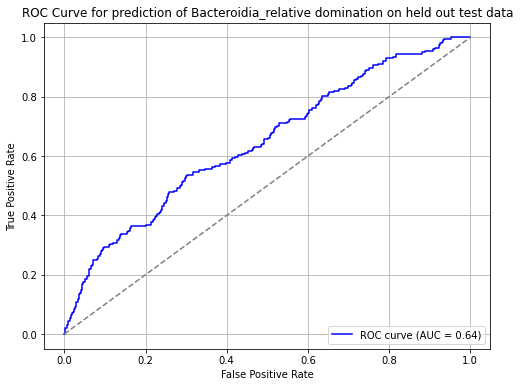

computing domination predictions...
plotting ROC curve...


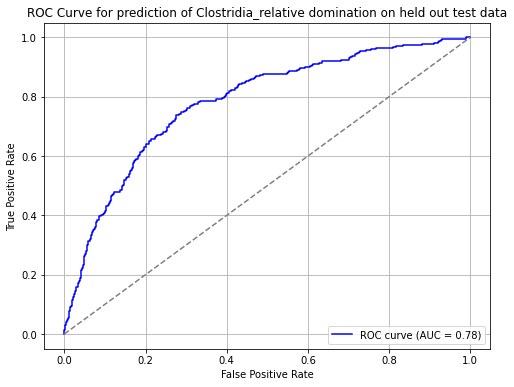

computing domination predictions...
plotting ROC curve...


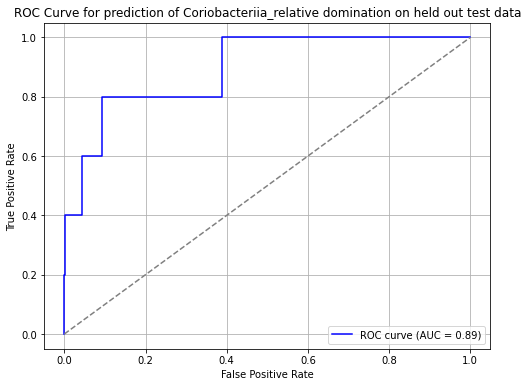

computing domination predictions...
plotting ROC curve...


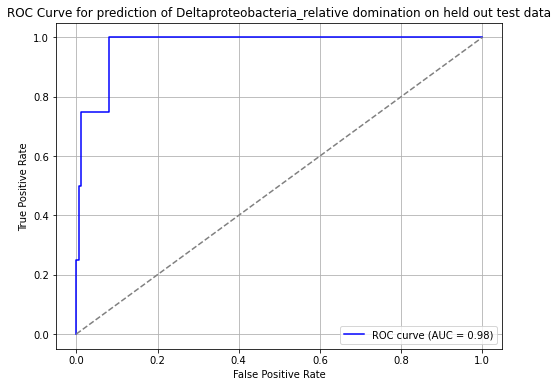

computing domination predictions...
plotting ROC curve...


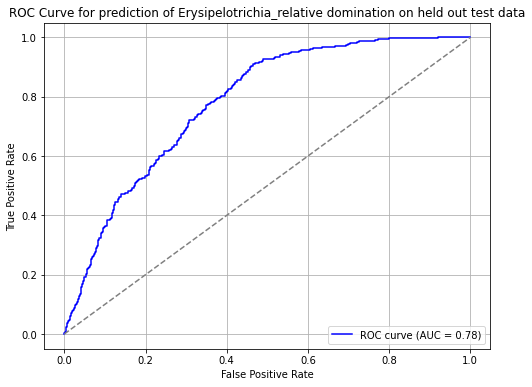

computing domination predictions...
plotting ROC curve...


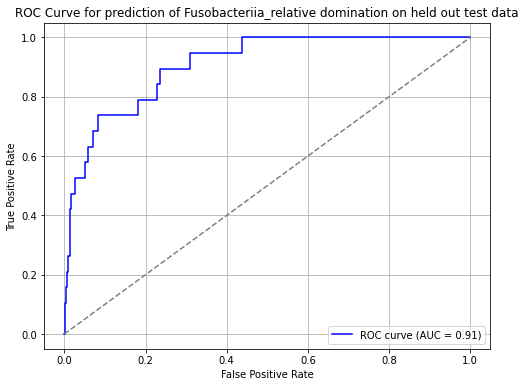

computing domination predictions...
plotting ROC curve...


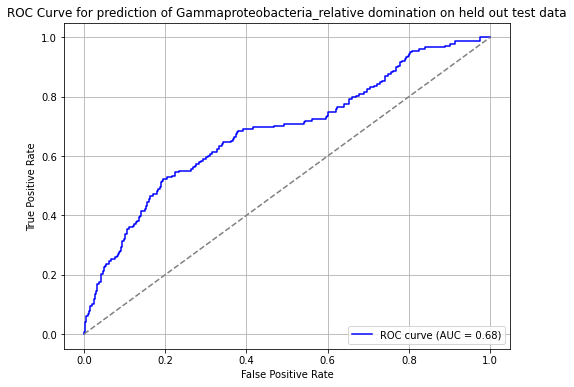

computing domination predictions...
plotting ROC curve...


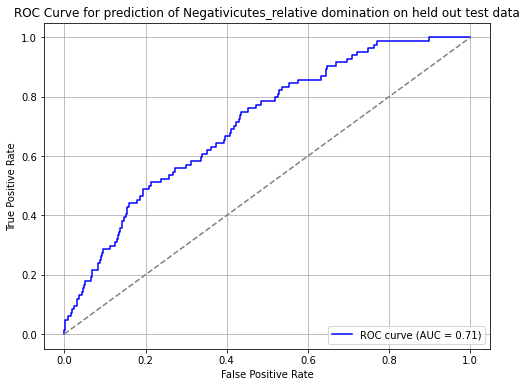

computing domination predictions...
plotting ROC curve...


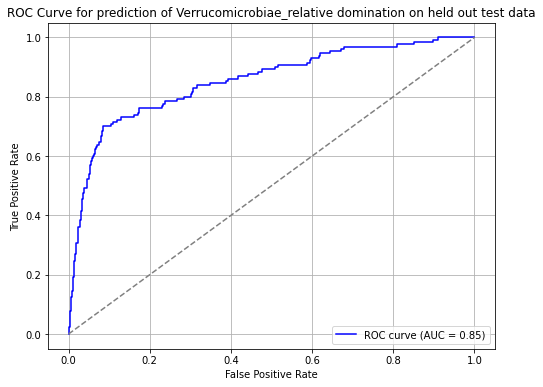

computing domination predictions...
plotting ROC curve...


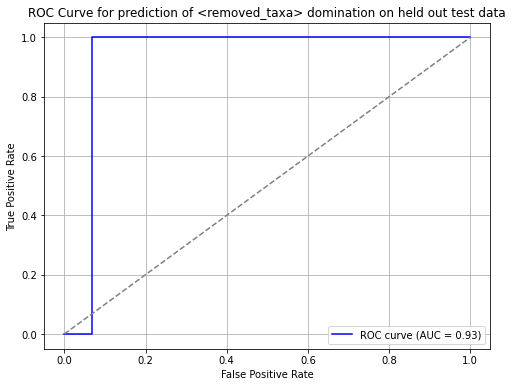

In [6]:
for i in range(13):
    MyModels.make_domination_predictions(node_model, test_df, index_of_taxa=i)


# Time series bar plots

In [2]:
node_model_test_df = pd.read_csv('node_model_test_df.csv', index_col = 0)
colors = ['#D0D0D0',
            '#F88379',
            '#006400',
            '#16DDD3',
            '#AD998C',
            '#D0D0D0',
            '#AA336A',
            '#FBA22E',
            '#D0D0D0',
            '#EE2C2C',
            '#D0D0D0',
            '#CA0BE8',
            '#808080']

classes = ["Actinobacteria",
    "Alphaproteobacteria",
    "Bacilli",
    "Bacteroidia",
    "Clostridia",
    "Coriobacteriia",
    "Deltaproteobacteria",
    "Erysipelotrichia",
    "Fusobacteriia",
    "Gammaproteobacteria",
    "Negativicutes",
    "Verrucomicrobiae",
    "<removed_taxa>"]

In [4]:


def make_prediction_plots(model, patient_id,test_df, fig_size=(6,3), time_range=None, normalized_only = True, 
                          glv_model = False, title = 'NODE Relative Abundance Predictions'):
    patient_id_df = test_df[test_df['PatientID'] == patient_id]
    t_true = torch.from_numpy(patient_id_df['DayRelativeToNearestHCT'].to_numpy()).to(device, torch.float32)
    x_true = torch.from_numpy(patient_id_df.iloc[:, :-3].to_numpy()).to(device, torch.float32)
    x_preds = torch.zeros((0,13)).to(device, torch.float32)
    t_preds = torch.linspace(t_true[0], t_true[-1]-1, int(t_true[-1]-t_true[0]))
    
    for i in range(len(t_true)-1):
        t0, tf = t_true[i], t_true[i+1]
        prediction_times = torch.linspace(t0+1, tf, int(tf-t0)).to(device)
        x0 = x_true[i, :]
        if glv_model: # needed to add this line because the glv uses float64
            x0 = x0.to(dtype = torch.float64)
        model.patient_id = patient_id
        x_preds = torch.cat([x_preds, odeint(model, x0, prediction_times)])

    def plot_stacked_bar_original(x, t, colors, title=title, time_range=None):
        x_np = x.cpu().detach().numpy()
        t_np = t.cpu().detach().numpy()
        x_np[x_np<0] = 0

        # Apply time range filter
        if time_range is not None:
            start, end = time_range
            mask = (t_np >= start) & (t_np <= end)
            t_np = t_np[mask]
            x_np = x_np[mask, :]

        fig, ax = plt.subplots(figsize=fig_size)
        bottom = np.zeros_like(t_np)
        for i in range(13):
            ax.bar(t_np, x_np[:,i], bottom=bottom, color=colors[i])
            bottom += x_np[:,i]
        plt.title(title)
        plt.show()

    def plot_stacked_bar_normalized(x, t, colors, time_range=None, title = title):
        x_np = x.cpu().detach().numpy()
        t_np = t.cpu().detach().numpy()
        x_np[x_np < 0] = 0
        row_sums = x_np.sum(1, keepdims=True)
        x_normalized = np.zeros_like(x_np)
        np.divide(x_np, row_sums, out=x_normalized, where=row_sums != 0)
        
        # Apply time range filter
        if time_range is not None:
            start, end = time_range
            mask = (t_np >= start) & (t_np <= end)
            t_np = t_np[mask]
            x_normalized = x_normalized[mask, :]
        fig, ax = plt.subplots(figsize=fig_size)
        bottom = np.zeros_like(t_np)
        for i in range(13):
            ax.bar(t_np, x_normalized[:,i], bottom=bottom, color=colors[i])
            bottom += x_normalized[:,i]
        ax.legend([f'{classes[i]}' for i in range(13)], bbox_to_anchor=(1.15,1))
        ax.set_ylabel('Normalized Predicted Values')
        plt.title(title+f' PatientID = {patient_id}')
        plt.show()

    # Plot with optional time range filtering
    if not normalized_only:
        plot_stacked_bar_original(x_preds, t_preds, colors, time_range=time_range)
    if not glv_model:     
        plot_stacked_bar_original(x_true, t_true, colors, 
                            title=f'True Relative Abundances PatientID = {patient_id}',
                            time_range=time_range)

    plot_stacked_bar_normalized(x_preds, t_preds, colors, time_range=time_range, title = title)
    return None


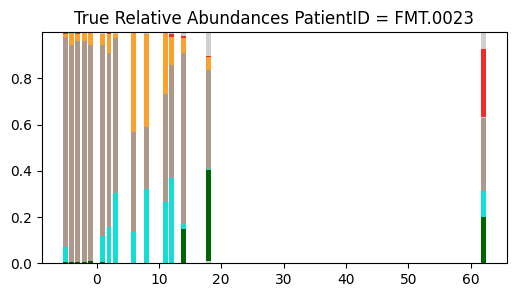

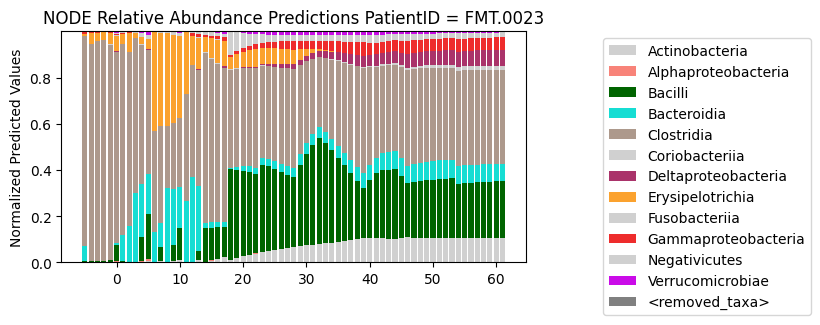

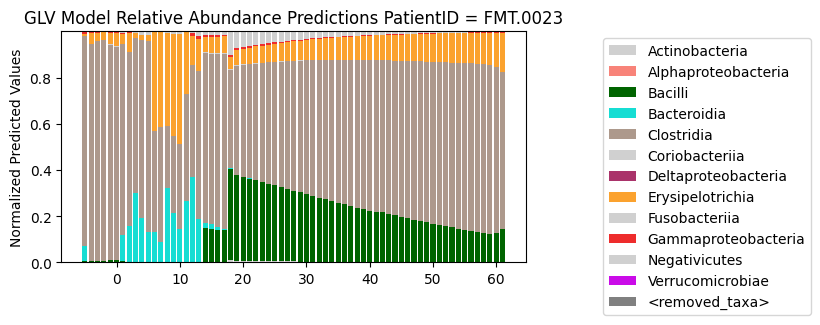

In [5]:

patient_id = 'FMT.0023'
make_prediction_plots(node_model, patient_id, node_model_test_df)
make_prediction_plots(glv_model, patient_id, glv_model_test_df, glv_model=True, title = 'GLV Model Relative Abundance Predictions')



In [67]:
for patient_id in glv_model_test_df['PatientID'].unique():
    if len(node_model_test_df[node_model_test_df['PatientID'] == patient_id]) == len(glv_model_test_df[glv_model_test_df['PatientID'] == patient_id]):
        print(patient_id)
    

1044
1158
1201
1203
1207
1244
1251
1252
1293
1303
1316
1331
1414
1580
1721
2065
2105
2163
2180
2196
FMT.0023
FMT.0062
FMT.0089
FMT.0130
FMT.0244


# Now add antibiotics to the plots

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


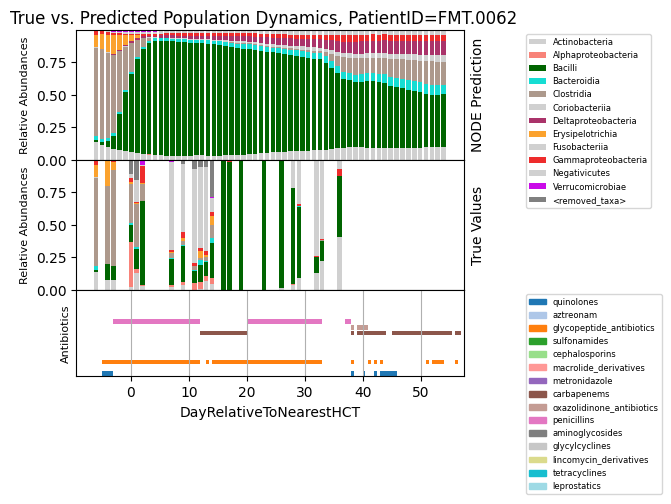

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


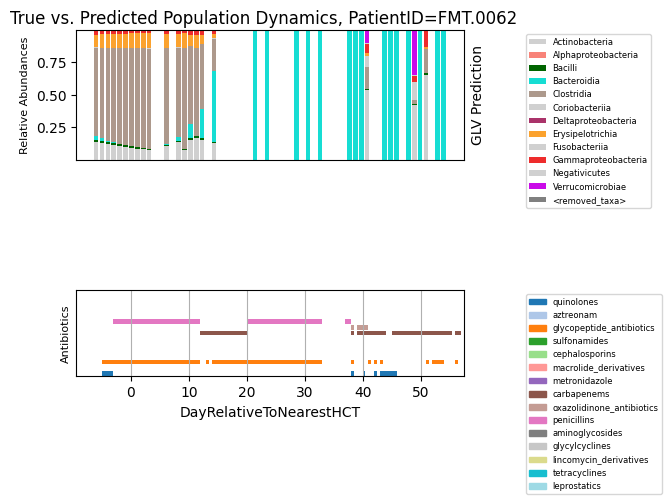

In [3]:
def make_prediction_plot_without_reseting(model, patient_id, x0_sample_id, test_df, df_antibiotics, antibiotic_types,  file_title,
                                          fig_size=(5,2), prediction_size = 7,
                                          glv_model = False, title = 'NODE Prediction', time_range=None):
    patient_id_df = test_df[test_df['PatientID'] == patient_id]
    sample_id_df = patient_id_df[patient_id_df['SampleID']==x0_sample_id]
    x0 = torch.from_numpy(sample_id_df.iloc[:, :-3].to_numpy()).to(device, torch.float32).squeeze(0)
    t0 = torch.from_numpy(sample_id_df['DayRelativeToNearestHCT'].to_numpy()).to(device, torch.float32)
    tf = t0+prediction_size
    t_preds = torch.linspace(t0.item(), tf.item(), int(tf-t0)).to(device)
    
    # Get ground truth data for this patient
    t_true = torch.from_numpy(patient_id_df['DayRelativeToNearestHCT'].to_numpy()).to(device, torch.float32)
    x_true = torch.from_numpy(patient_id_df.iloc[:, :-3].to_numpy()).to(device, torch.float32)
    
    if glv_model: # needed to add this line because the glv uses float64
        x0 = x0.to(dtype = torch.float64)
    model.patient_id = patient_id
    x_preds = odeint(model, x0, t_preds)
    
    def plot_stacked_bar_normalized(x_preds, t_preds, x_true, t_true, colors, time_range=None, title = title):
        # Process predictions
        x_pred_np = x_preds.cpu().detach().numpy()
        t_pred_np = t_preds.cpu().detach().numpy()
        x_pred_np[x_pred_np < 0] = 0
        row_sums_pred = x_pred_np.sum(1, keepdims=True)
        x_pred_normalized = np.zeros_like(x_pred_np)
        np.divide(x_pred_np, row_sums_pred, out=x_pred_normalized, where=row_sums_pred != 0)
        
        # Process ground truth
        x_true_np = x_true.cpu().detach().numpy()
        t_true_np = t_true.cpu().detach().numpy()
        x_true_np[x_true_np < 0] = 0
        row_sums_true = x_true_np.sum(1, keepdims=True)
        x_true_normalized = np.zeros_like(x_true_np)
        np.divide(x_true_np, row_sums_true, out=x_true_normalized, where=row_sums_true != 0)
        
        # Apply time range filter
        if time_range is not None:
            start, end = time_range
            # Filter predictions
            mask_pred = (t_pred_np >= start) & (t_pred_np <= end)
            t_pred_np = t_pred_np[mask_pred]
            x_pred_normalized = x_pred_normalized[mask_pred, :]
            # Filter ground truth
            mask_true = (t_true_np >= start) & (t_true_np <= end)
            t_true_np = t_true_np[mask_true]
            x_true_normalized = x_true_normalized[mask_true, :]
            
        # Filter antibiotic data for this patient and time range
        patient_antibiotics = df_antibiotics[df_antibiotics['PatientID'] == patient_id].copy()
        if time_range is not None:
            start, end = time_range
            # Keep antibiotics that overlap with the time range
            patient_antibiotics = patient_antibiotics[
                (patient_antibiotics['StopDayRelativeToNearestHCT'] >= start) & 
                (patient_antibiotics['StartDayRelativeToNearestHCT'] <= end)
            ]
            
        # Create figure with subplots - no space between plots
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(fig_size[0], fig_size[1] + 2.5), 
                                           gridspec_kw={'height_ratios': [3, 3, 2], 'hspace': 0})
        
        fig.suptitle(f'True vs. Predicted Population Dynamics, PatientID={patient_id}', y=0.925)
        # Predictions plot
        bottom_pred = np.zeros_like(t_pred_np)
        for i in range(13):
            ax1.bar(t_pred_np, x_pred_normalized[:,i], bottom=bottom_pred, color=colors[i])
            bottom_pred += x_pred_normalized[:,i]
        ax1.legend([f'{classes[i]}' for i in range(13)], bbox_to_anchor=(1.15,1), fontsize = 6)
        ax1.set_ylabel('Relative Abundances', fontsize = 8)
        # Move title to the right side
        ax1.text(1.02, 0.5, title, transform=ax1.transAxes, 
                rotation=90, verticalalignment='center', fontsize=10)
        # Remove x-axis labels and ticks for top plot
        ax1.set_xticklabels([])
        ax1.tick_params(axis='x', which='both', bottom=False)
        
        # Ground truth plot
        if not glv_model and len(t_true_np) > 0:  # Only plot if we have ground truth data
            bottom_true = np.zeros_like(t_true_np)
            for i in range(13):
                ax2.bar(t_true_np, x_true_normalized[:,i], bottom=bottom_true, color=colors[i])
                bottom_true += x_true_normalized[:,i]
            ax2.set_ylabel('Relative Abundances', fontsize = 8)
            # Move title to the right side
            ax2.text(1.02, 0.5, f'True Values', 
                    transform=ax2.transAxes, rotation=90, verticalalignment='center', fontsize=10)
            ax2.set_xlim(ax1.get_xlim())  # Match x-axis range with predictions plot
            # Remove x-axis labels and ticks for middle plot
            ax2.set_xticklabels([])
            ax2.tick_params(axis='x', which='both', bottom=False)
        else:
            ax2.set_visible(False)  # Hide the ground truth subplot if no data
            
        # Antibiotic treatment bars
        ax3.set_xlim(ax1.get_xlim())  # Match x-axis range with main plot
        ax3.set_ylim(-0.5, len(antibiotic_types) - 0.5)
        
        # Create color map for antibiotics
        antibiotic_colors = plt.cm.tab20(np.linspace(0, 1, len(antibiotic_types)))
        antibiotic_color_map = {antibiotic: antibiotic_colors[i] for i, antibiotic in enumerate(antibiotic_types)}
        
        # Plot antibiotic bars and collect handles for legend
        antibiotic_handles = []
        for _, row in patient_antibiotics.iterrows():
            antibiotic = row['Category']
            start_day = row['StartDayRelativeToNearestHCT']
            stop_day = row['StopDayRelativeToNearestHCT']
            
            if antibiotic in antibiotic_types:
                y_pos = antibiotic_types.index(antibiotic)
                width = stop_day - start_day if stop_day != start_day else 0.5  # Minimum width for single-day treatments
                bar = ax3.barh(y_pos, width, left=start_day, height=0.8, 
                              color=antibiotic_color_map[antibiotic], alpha=1, 
                              label=antibiotic)
                
        # Create legend handles for all antibiotics (even if not present in this patient)
        for antibiotic in antibiotic_types:
            antibiotic_handles.append(plt.Rectangle((0,0),1,1, color=antibiotic_color_map[antibiotic], 
                                                   alpha=1, label=antibiotic))
        
        # Customize antibiotic subplot
        ax3.set_yticks([])  # Remove y-axis ticks and labels
        ax3.set_xlabel('DayRelativeToNearestHCT')
        ax3.set_ylabel('Antibiotics', fontsize=8)
        # Move antibiotic section title to the right side
        # ax3.text(1.02, 0.5, 'Antibiotics', transform=ax3.transAxes, 
        #         rotation=90, verticalalignment='center', fontsize=12)
        ax3.grid(True, alpha=1)
        
        # Add antibiotic legend
        ax3.legend(handles=antibiotic_handles, bbox_to_anchor=(1.15, 1), 
                  loc='upper left', fontsize=6)
        plt.savefig(f'./eps_figures/model_predictions_patientID={patient_id}_{file_title}.eps', format="eps", bbox_inches='tight')
        plt.show()
        
    plot_stacked_bar_normalized(x_preds, t_preds, x_true, t_true, colors, time_range=time_range, title = title)


patient_id = 'FMT.0062'
x0_sample_id = patient_id+'B'
prediction_size = 60
make_prediction_plot_without_reseting(node_model,patient_id,x0_sample_id,  node_model_test_df,df_antibiotics, antibiotic_types, 'node', prediction_size=prediction_size) 
make_prediction_plot_without_reseting(glv_model,patient_id,x0_sample_id,  glv_model_test_df,df_antibiotics, antibiotic_types, 'glv', title = 'GLV Prediction', glv_model= True,prediction_size=prediction_size)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


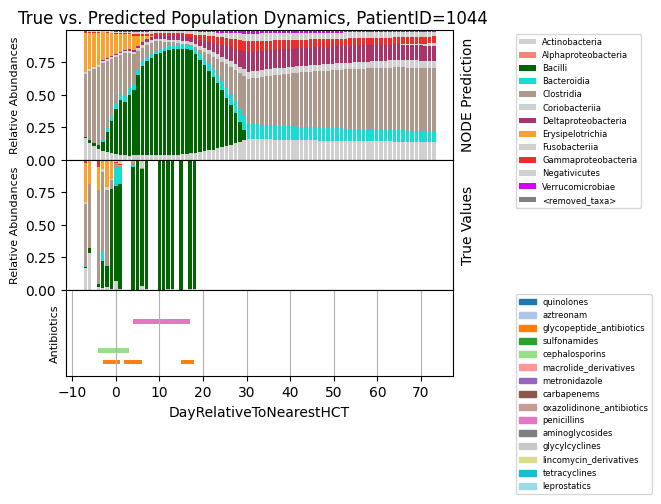

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


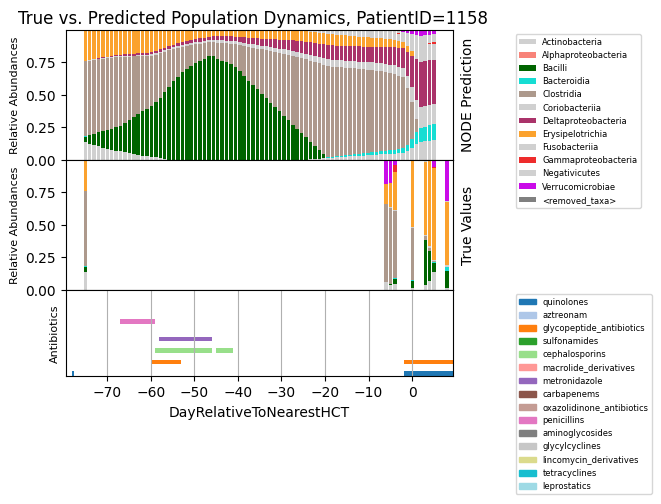

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


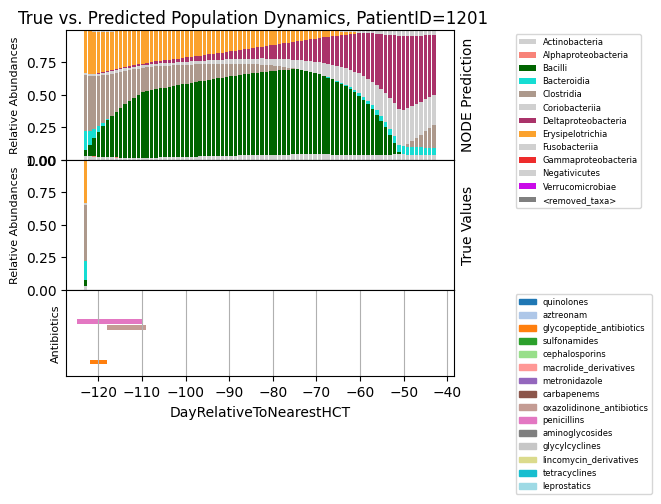

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


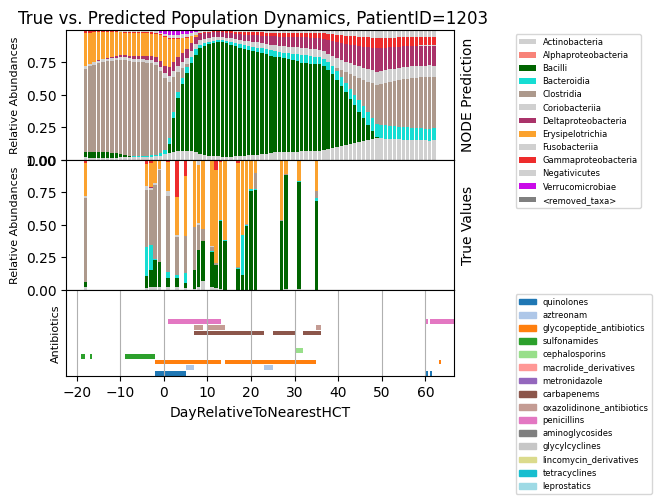

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


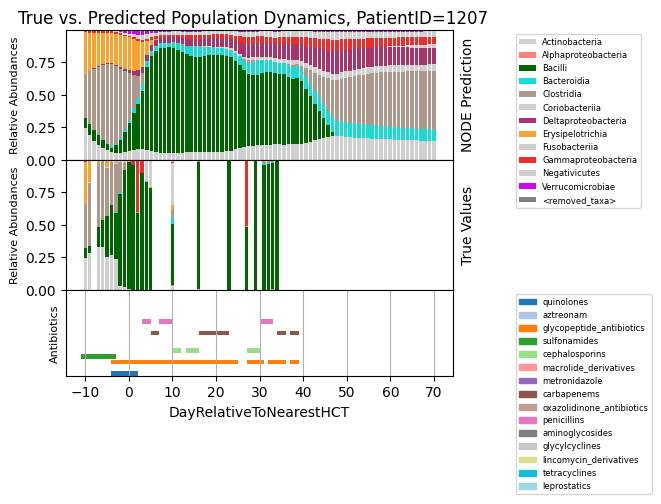

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


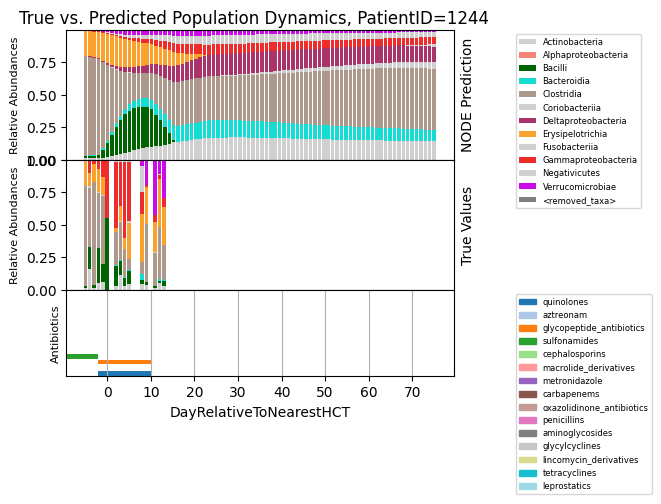

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


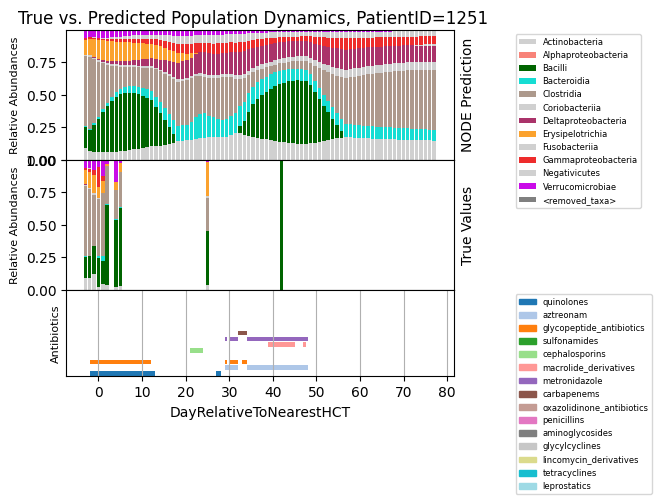

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


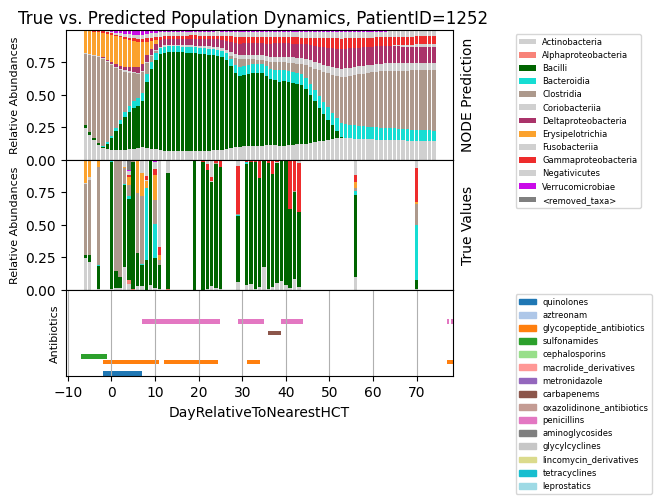

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


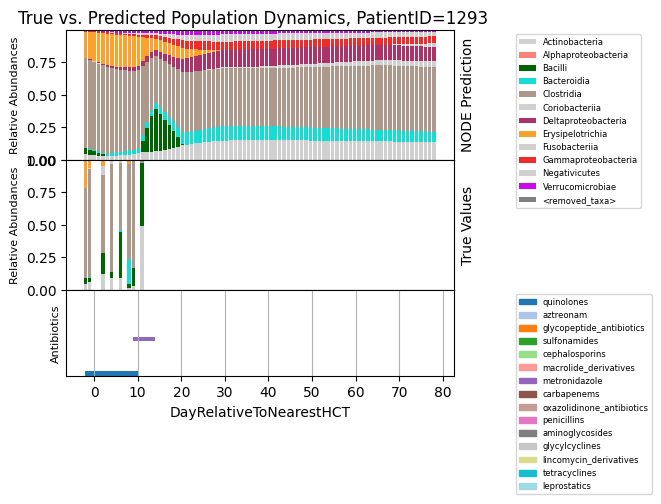

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


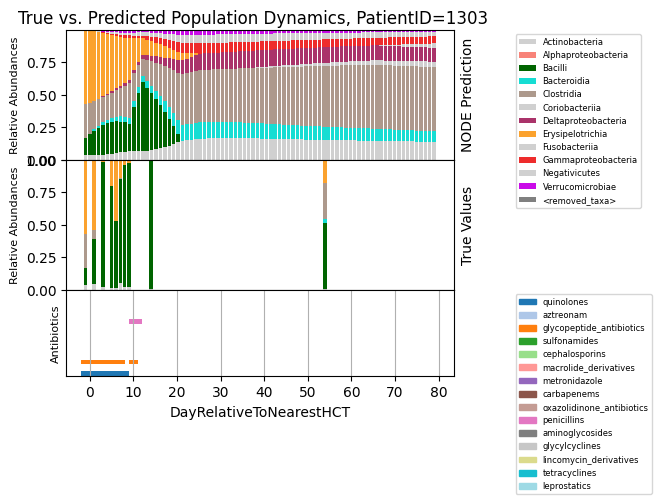

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


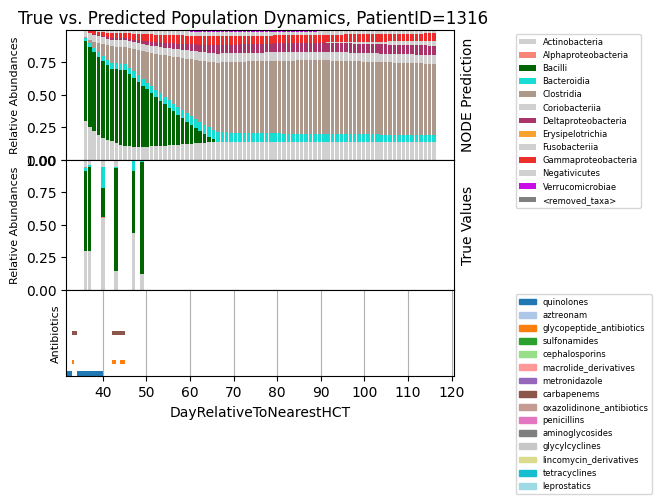

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


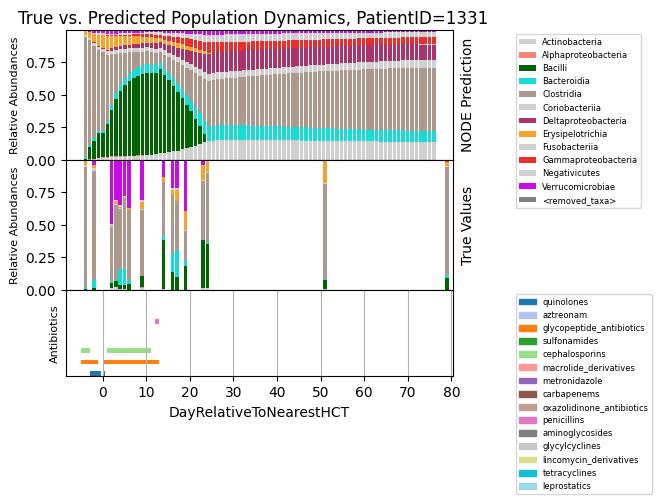

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


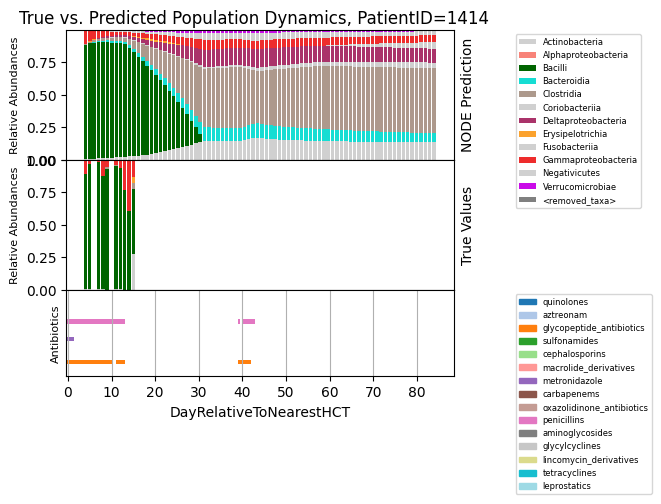

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


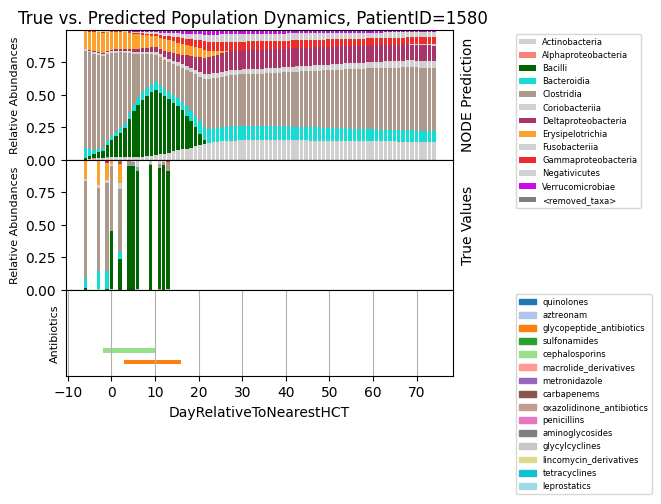

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


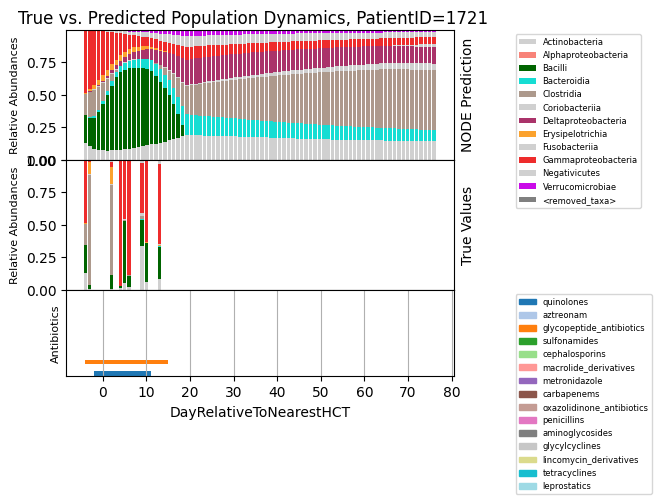

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


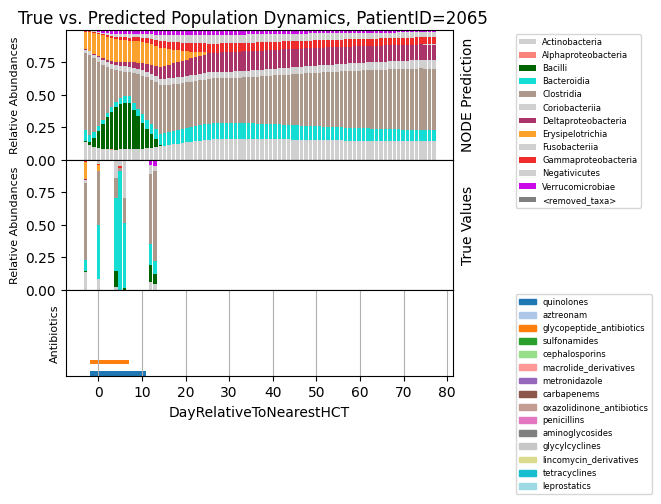

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


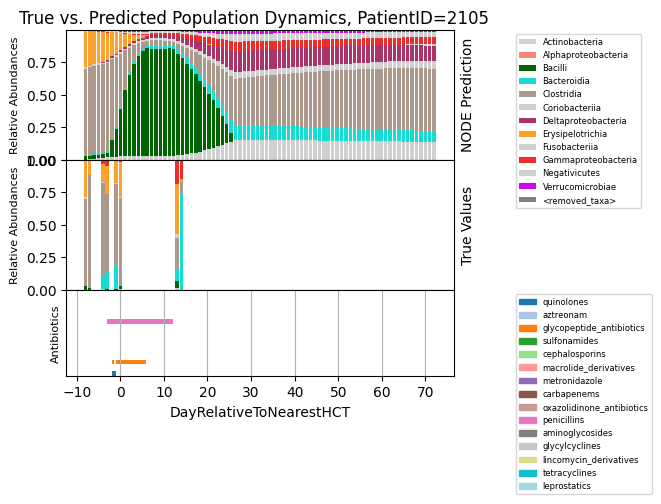

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


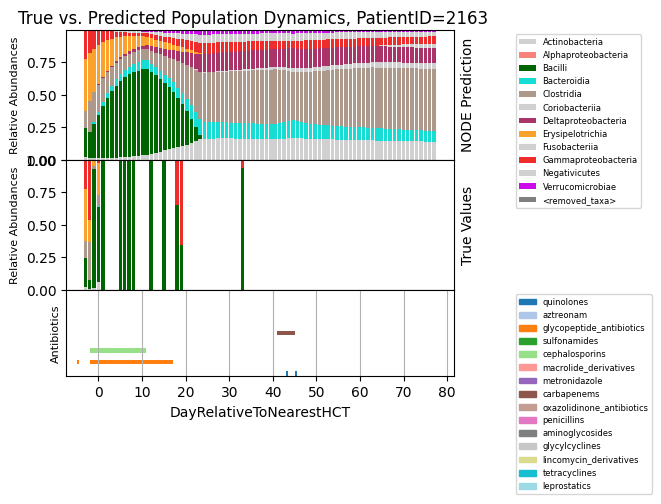

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


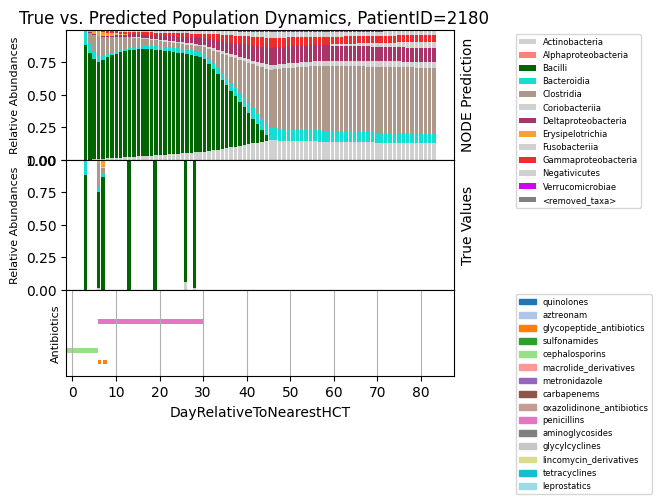

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


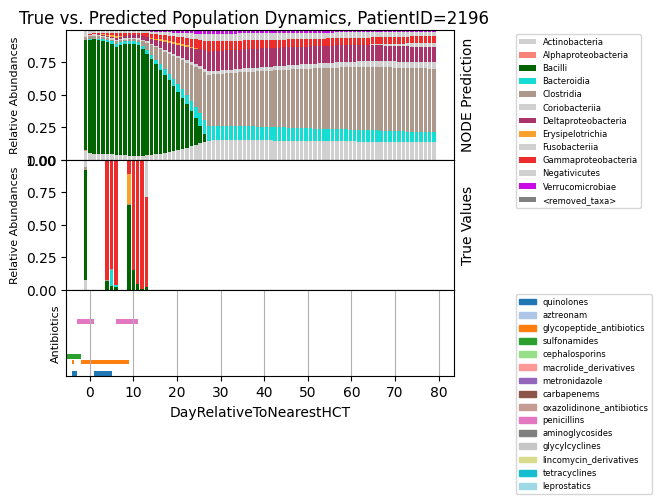

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


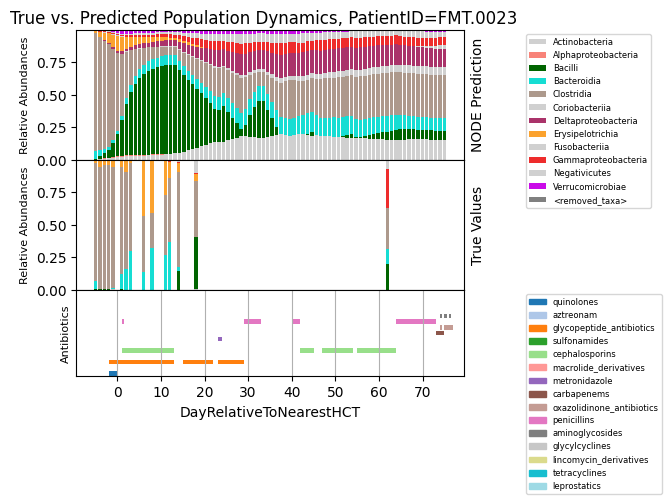

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


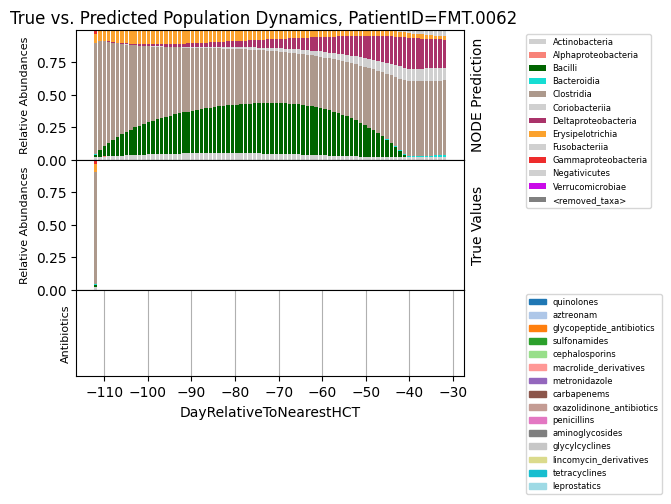

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


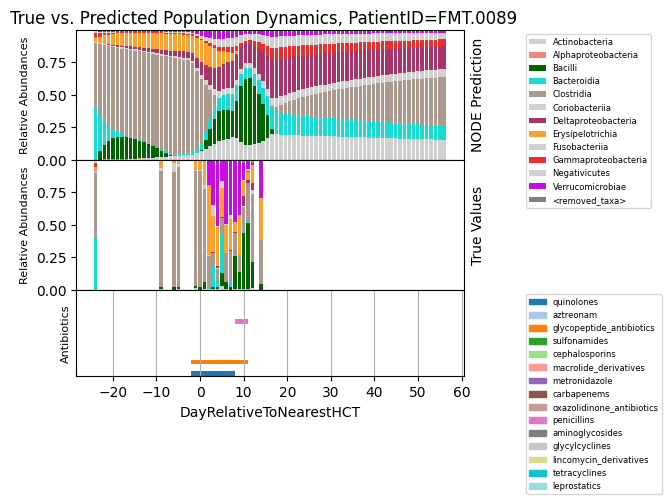

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


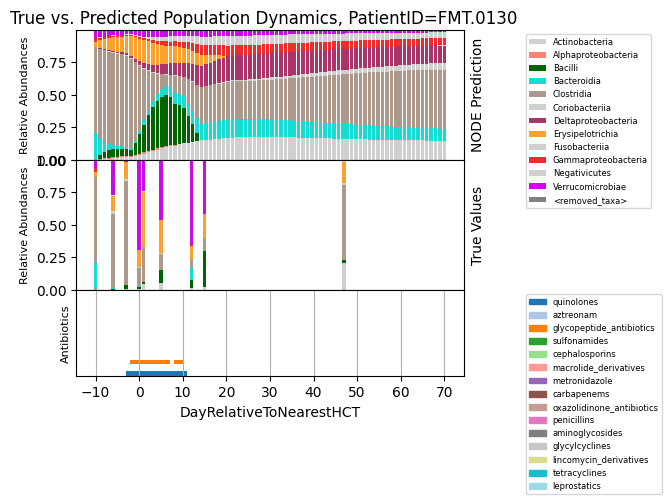

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


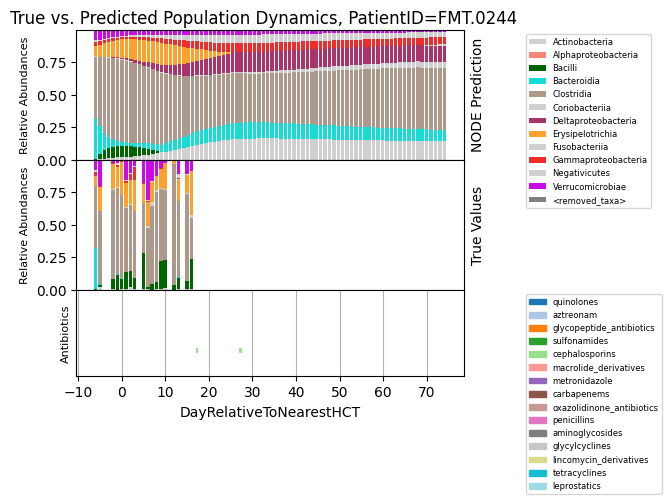

In [4]:
prediction_size = 80
for patient_id in glv_model_test_df['PatientID'].unique():
    if len(node_model_test_df[node_model_test_df['PatientID'] == patient_id]) == len(glv_model_test_df[glv_model_test_df['PatientID'] == patient_id]):
        x0_sample_id = list(node_model_test_df[node_model_test_df['PatientID'] == patient_id]['SampleID'])[0]
        make_prediction_plot_without_reseting(node_model,patient_id,x0_sample_id,  node_model_test_df,df_antibiotics, antibiotic_types, 'node', prediction_size=prediction_size) 
        